In [3]:
# Compute present value of the liabilities
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

erk.discout(10, 0.03)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SyntaxError: unmatched ')' (edhec_risk_kit.py, line 626)

In [ ]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities
erk.pv(liabilities, 0.03)

In [ ]:
liabilities.sum()

In [ ]:
erk.funding_ratio(5, liabilities, 0.03) # underfunded vs liabilities

In [ ]:
def show_funding_ratio(assets, r):
    fr = erk.funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}%')

controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

# CIR Model to simulate changes in Interest Rates and Liability Hedging

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

In [17]:
def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    :param r:
    :return:
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert annualized to a short rate
    :param r:
    :return:
    """
    return np.log1p(r)


In [20]:

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float

    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ####

    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####

    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))



controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

<AxesSubplot:>

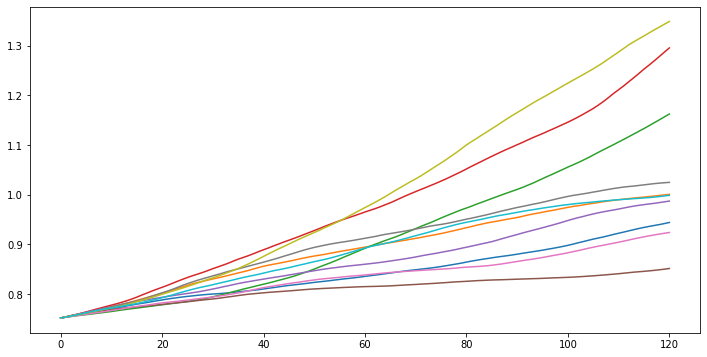

In [23]:
a_0 = 0.75
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10, n_years=10)
liabilities = bond_prices
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

av_cash.plot(legend=False, figsize=(12, 6))


<AxesSubplot:>

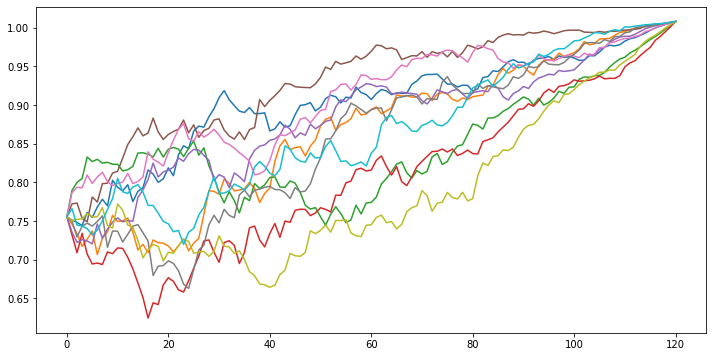

In [25]:
av_zc_bonds.plot(legend=False, figsize=(12, 6))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 Scenarios)'}>

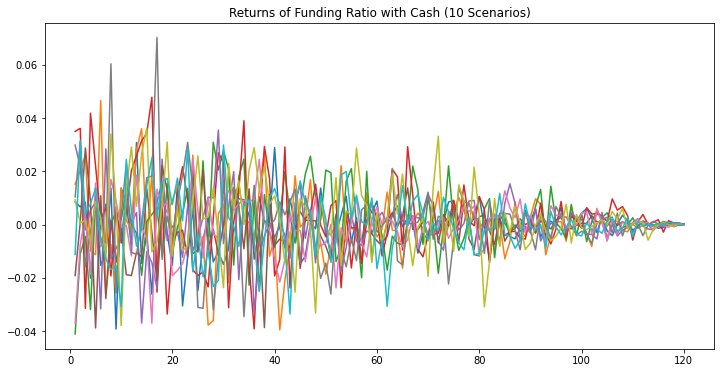

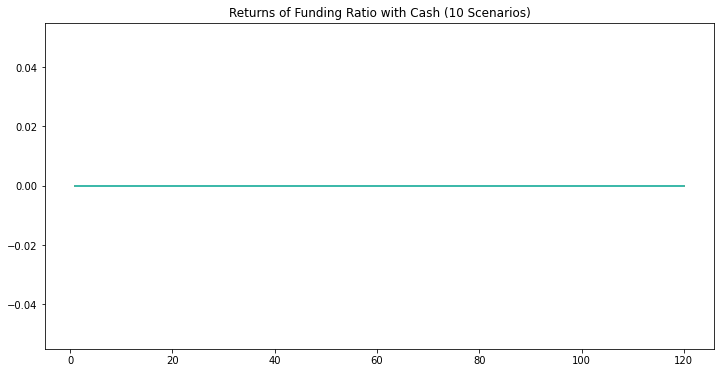

In [29]:
(av_cash/av_zc_bonds).pct_change().plot(title='Returns of Funding Ratio with Cash (10 Scenarios)', legend=False,
                                        figsize=(12, 6))

(av_zc_bonds/av_zc_bonds).pct_change().plot(title='Returns of Funding Ratio with Cash (10 Scenarios)', legend=False,
                                        figsize=(12, 6))

<AxesSubplot:>

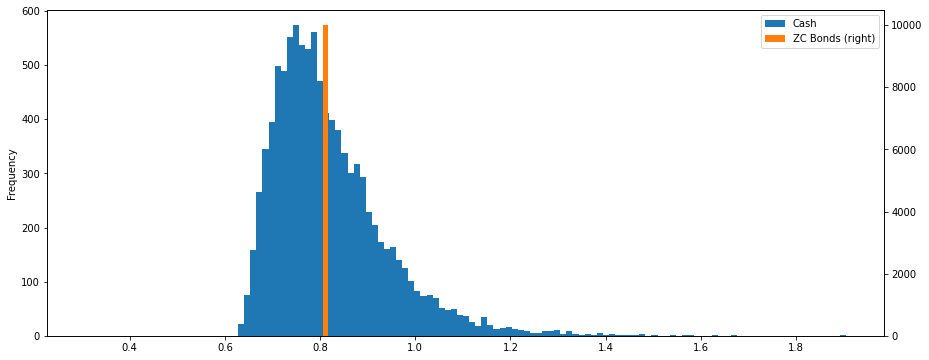

In [34]:
a_0 = 0.6
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(pd.Series(data=[1], index=[10]), 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bond = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label='Cash', figsize=(15, 6), bins = 100, legend=True)
tfr_zc_bond.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)
